In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.polynomial import Polynomial

def clean_plot(fig, ax, X, Y, data):
    sc = ax.scatter(X.flatten(), Y.flatten(), c=data.flatten(), cmap="plasma")
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(sc, cax=cax)
    cbar.ax.tick_params(labelsize=12)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')

def corr(a, b):
    return np.mean(a*b) / np.sqrt(np.mean(a**2)*np.mean(b**2))

<br>

$$\large
\nabla \cdot ( \mathcal{K}\cdot \nabla \psi) \ = \ -\lambda \, \mathcal{C}\, \psi
$$

<br>

$$\large
\nabla \cdot ( \mathcal{K}_{0}\cdot \nabla \psi_{0}) \ = \ -\lambda_{0} \, \mathcal{C}_{0}\, \psi_{0}
$$

<br>

$$\large
\nabla \cdot ( \mathcal{K}_{0}\cdot \nabla \psi_{1}) + \nabla \cdot ( \mathcal{K}_{1}\cdot \nabla \psi_{0}) \ = \ -\lambda_{0} \, \mathcal{C}_{0}\, \psi_{1} -\lambda_{0} \, \mathcal{C}_{1}\, \psi_{0} -\lambda_{1} \, \mathcal{C}_{0}\, \psi_{0} 
$$

<br>

$$\large
\lambda_{1} \ = \ \frac{\left< \nabla \psi_{0} \cdot \mathcal{K}_{1} \cdot \nabla \psi_{0} \right> - \lambda_{0} \left< \psi_{0} \, \mathcal{C}_{1}\,\psi_{0}\right>}{\left< \psi_{0} \, \mathcal{C}_{0}\,\psi_{0}\right>}
$$

## Read in data

In [3]:
with open("../data/inhomogeneous_random_delaunay_homogenization_data.pkl", "rb") as file:
    data = pickle.load(file)

N_r = np.max(np.array(list(data.keys()))[:, 0]) + 1
N_theta = np.max(np.array(list(data.keys()))[:, 1]) + 1

K  = np.array([value[0] for value in data.values()]).reshape(N_r, N_theta, 2, 2)                # K[n, m, i, j] = i,j entry of K at (x[n], y[m])
C  = np.array([value[1] for value in data.values()]).reshape(N_r, N_theta)                      # C[n, m]       = C at (x[n], y[m])
mu = np.array([value[2] for value in data.values()]).reshape(N_r, N_theta).astype(np.float64)   # mu[n, m]      = mu at (x[n], y[m]) 
patch_side_lengths = np.array([value[3] for value in data.values()]).reshape(N_r, N_theta)

# Parameters
inner_r, outer_r = 0.1, 1.0
r_grid = np.linspace(inner_r, outer_r, N_r + 6)[3:-3]
θ_grid = np.linspace(0, 2*np.pi, N_theta, endpoint=False)
R, Theta = np.meshgrid(r_grid, θ_grid, indexing='ij')
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

## Plot data

In [8]:
mu /= patch_side_lengths**2

C *= patch_side_lengths

for i in range(2):
    for j in range(2):
        K[:, :, i, j] *= patch_side_lengths

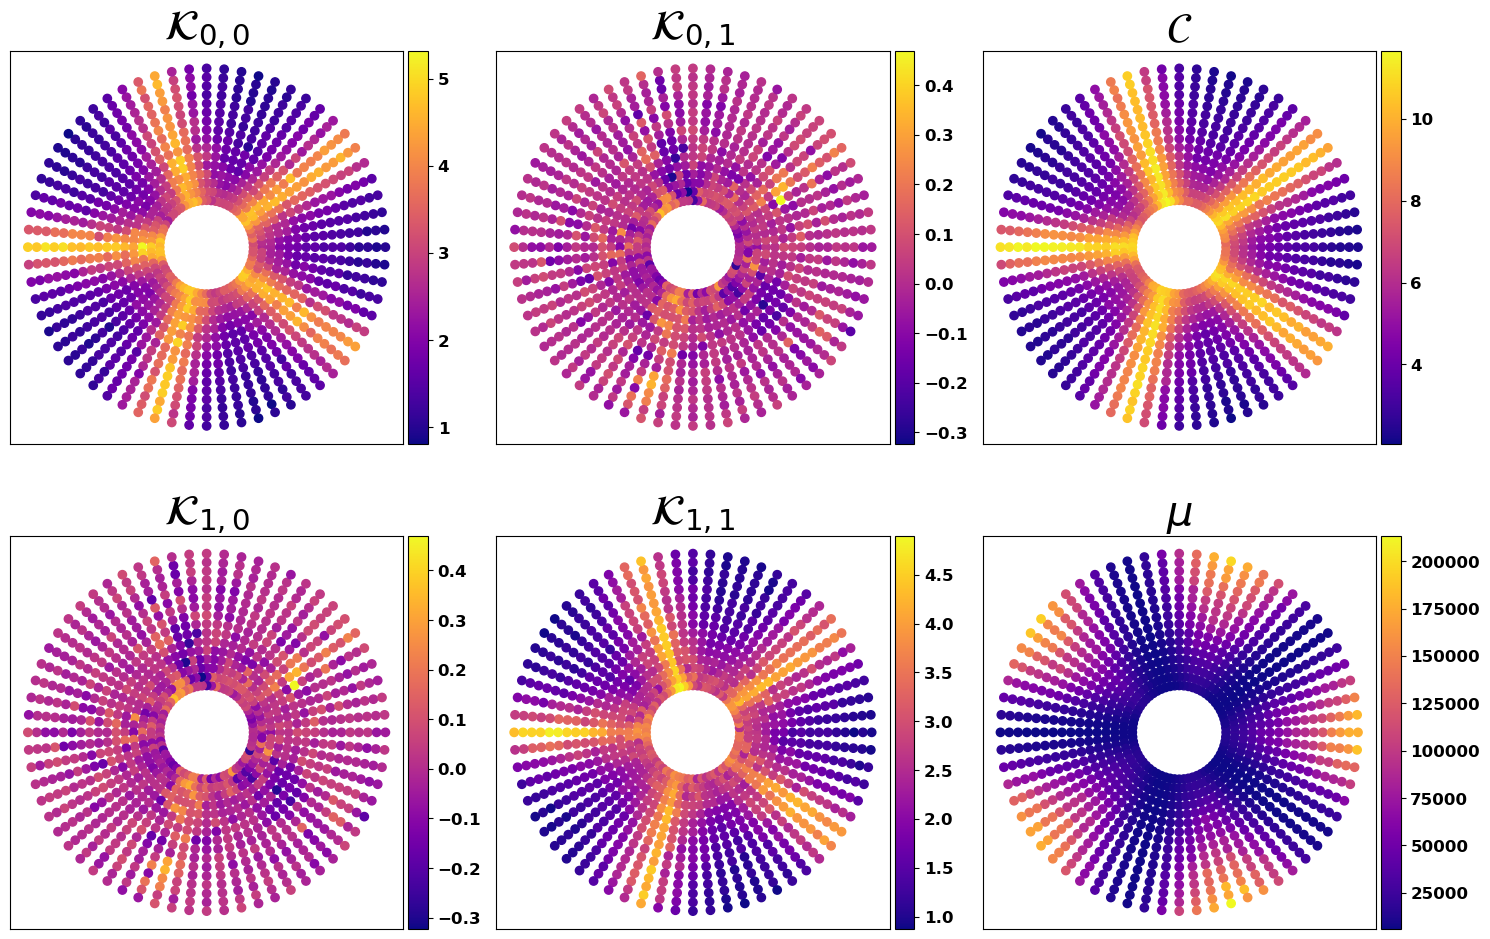

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(3*10/2, 10))

for i in range(2):
    for j in range(2):
        clean_plot(fig, ax[i, j], X, Y, K[:, :, i, j])
        ax[i, j].set_title(fr"$\mathcal{{K}}_{{{i},{j}}}$", fontsize=30)

i, j = 0, 2
clean_plot(fig, ax[i, j], X, Y, C)
ax[i, j].set_title(fr"$\mathcal{{C}}$", fontsize=30)

i, j = 1, 2
clean_plot(fig, ax[i, j], X, Y, mu)
ax[i, j].set_title(fr"$\mu$", fontsize=30)

plt.tight_layout()

plt.show()

## Rescale to reduce magnitudes

In [10]:
mu /= np.max(mu)
K /= np.max(C)
C /= np.max(C)

## Look at correlations

In [11]:
print(1 - corr(mu*K[:, :, 0, 0], mu*K[:, :, 1, 1]))
print(1 - corr(mu*K[:, :, 0, 0], mu*C))
print(1 - corr(mu*K[:, :, 1, 1], mu*C))
print()
print(corr(mu*K[:, :, 0, 1], mu*C))
print(corr(mu*K[:, :, 0, 1], mu*K[:, :, 0, 0]))

0.00412692065500786
0.0015110437331508075
0.0021407748881373534

-0.0037954298068416928
-0.004245685497089975


## Interpolate

In [12]:
μC  = mu*C
μK0 = mu*K[:,:,0,0]
μK1 = mu*K[:,:,1,1]
μK2 = mu*K[:,:,0,1]

μC_r = np.mean(μC, axis=1)
μC_θ = np.mean(μC * (r_grid * μC_r)[:, None], axis=0) / np.mean(r_grid * μC_r**2)

A = np.fft.rfft(μC_θ)
A = A[:20:5]/len(μC_θ)
A[1:] *= 2
μC_θ_fun = lambda θ: sum(a.real*np.cos(5*k*θ) - a.imag*np.sin(5*k*θ) for k, a in enumerate(A))

μK0_r = np.mean(μK0 * μC_θ_fun(θ_grid)[None, :], axis=1) / np.mean(μC_θ_fun(θ_grid)**2)
μK1_r = np.mean(μK1 * μC_θ_fun(θ_grid)[None, :], axis=1) / np.mean(μC_θ_fun(θ_grid)**2)

μC_r_fun  = Polynomial.fit(r_grid,  μC_r, deg=1)
μK0_r_fun = Polynomial.fit(r_grid, μK0_r, deg=1)
μK1_r_fun = Polynomial.fit(r_grid, μK1_r, deg=1)

print(μC_r_fun)
print(μK0_r_fun)
print(μK1_r_fun)
print()

dμC  =  μC -  μC_r_fun(r_grid)[:,None] * μC_θ_fun(θ_grid)[None,:]
dμK0 = μK0 - μK0_r_fun(r_grid)[:,None] * μC_θ_fun(θ_grid)[None,:]
dμK1 = μK1 - μK1_r_fun(r_grid)[:,None] * μC_θ_fun(θ_grid)[None,:]


print('1-norm')
norm = lambda f: np.sum(np.abs(f))

print( norm(dμC)  /  norm(μC) )
print( norm(dμK0) / norm(μK0) )
print( norm(dμK1) / norm(μK1) )

print()

print('2-norm')
norm = np.linalg.norm

print( norm(dμC)  /  norm(μC) )
print( norm(dμK0) / norm(μK0) )
print( norm(dμK1) / norm(μK1) )

print()

print('max-norm')
norm = lambda f: np.max(np.abs(f))

print( norm(dμC)  /  norm(μC) )
print( norm(dμK0) / norm(μK0) )
print( norm(dμK1) / norm(μK1) )

print("\n\n")
full_muK = np.zeros_like(K)
full_muK[:, :, 0, 0] = mu * K[:, :, 0, 0]
full_muK[:, :, 0, 1] = mu * K[:, :, 0, 1]
full_muK[:, :, 1, 0] = mu * K[:, :, 1, 0]
full_muK[:, :, 1, 1] = mu * K[:, :, 1, 1]
full_muK /= np.linalg.norm(full_muK)
full_sep_muK = np.zeros_like(K)
full_sep_muK[:, :, 0, 0] = μK0_r_fun(r_grid)[:,None] * μC_θ_fun(θ_grid)[None,:]
full_sep_muK[:, :, 1, 1] = μK1_r_fun(r_grid)[:,None] * μC_θ_fun(θ_grid)[None,:]
full_sep_muK /= np.linalg.norm(full_sep_muK)
print("muK - muK_separated")
print(np.linalg.norm(full_muK - full_sep_muK))

0.07327469 + 0.03733324·(-1.71111111 + 3.11111111x)
0.03049139 + 0.01677765·(-1.71111111 + 3.11111111x)
0.02990292 + 0.01692477·(-1.71111111 + 3.11111111x)

1-norm
0.04803794560762169
0.06668236341961911
0.07092639124022469

2-norm
0.055791121046696646
0.07852817448866782
0.07795530434081081

max-norm
0.0984898180192292
0.1920341405921164
0.133368256978721



muK - muK_separated
0.08351934704165108


In [13]:
class coeff_interp():

    def __init__(self,data,modes,radius,degree):
        A = np.fft.rfft(data,axis=1)/data.shape[1]
        self.data = {}
        self.modes = modes
        A[:,1:] *= 2
        for k in modes: 
            self.data[k] = Polynomial.fit(radius,A[:,k],deg=degree)
    
    def __getitem__(self,item):
        return self.data[item]

    def __call__(self,radius,angle):
        return sum(self[k](radius).real*np.cos(k*angle) - self[k](radius).imag*np.sin(k*angle) for k in self.modes)

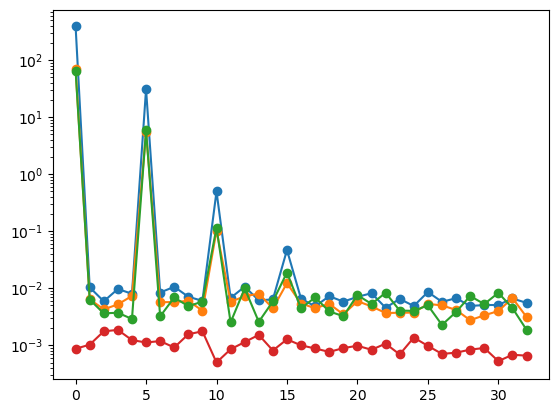

In [14]:
S = np.sum(np.abs(np.fft.rfft(μC,axis=1))**2,axis=0)
plt.semilogy(S,'-o')

S = np.sum(np.abs(np.fft.rfft(μK0,axis=1))**2,axis=0)
plt.semilogy(S,'-o')

S = np.sum(np.abs(np.fft.rfft(μK1,axis=1))**2,axis=0)
plt.semilogy(S,'-o')

S = np.sum(np.abs(np.fft.rfft(μK2,axis=1))**2,axis=0)
plt.semilogy(S,'-o')

In [15]:
dμC_fun  = coeff_interp(dμC,(0,5,10,15),r_grid,2)
dμK0_fun = coeff_interp(dμK0,(0,5,10,15),r_grid,2)
dμK1_fun = coeff_interp(dμK1,(0,5,10,15),r_grid,2)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8b/5pwswrrj2_1fnds4rv56brqw0000gp/T/ipykernel_76757/2124775149.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax[1].plot(θ_grid, μC_θ, 'o',label="$(\mu \mathcal{{C}})_{\\theta}$")


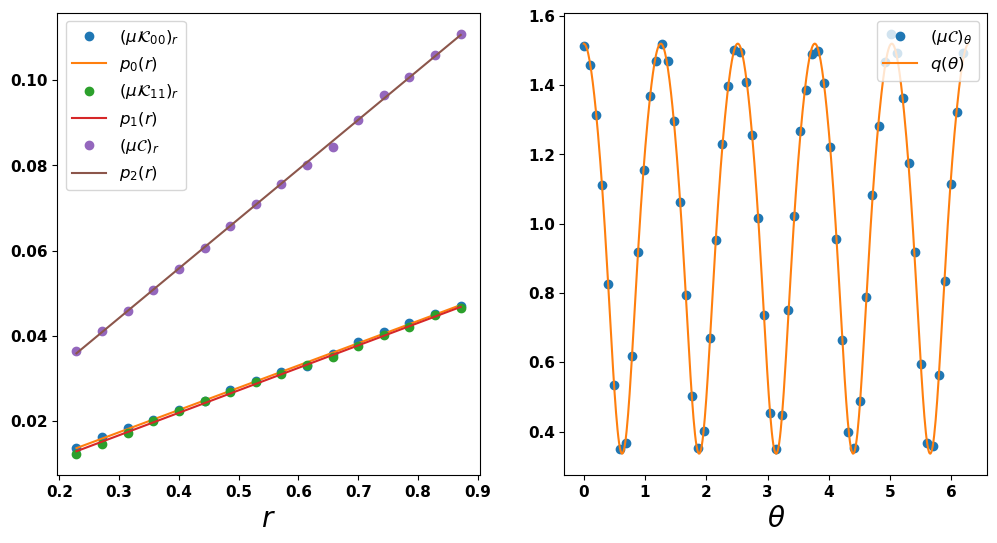

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(r_grid, μK0_r, 'o', label=fr"$(\mu \mathcal{{K}}_{{00}})_r$")
ax[0].plot(r_grid, μK0_r_fun(r_grid), label=fr"$p_0(r)$")

ax[0].plot(r_grid, μK1_r, 'o', label=fr"$(\mu \mathcal{{K}}_{{11}})_r$")
ax[0].plot(r_grid, μK1_r_fun(r_grid), label=fr"$p_1(r)$")

ax[0].plot(r_grid, μC_r, 'o', label=fr"$(\mu \mathcal{{C}})_r$")
ax[0].plot(r_grid, μC_r_fun(r_grid), label=fr"$p_2(r)$")

ax[0].set_xlabel("$r$", fontsize=20, fontweight='bold')

ax[1].plot(θ_grid, μC_θ, 'o',label="$(\mu \mathcal{{C}})_{\\theta}$")
ax[1].plot(np.linspace(0, 2*np.pi, 512, endpoint=False), μC_θ_fun(np.linspace(0, 2*np.pi, 512, endpoint=False)),label="$q(\\theta)$")
ax[1].set_xlabel("$\\theta$", fontsize=20)

ax[0].legend(loc="upper left", fontsize=12)
ax[1].legend(loc="upper right", fontsize=12)

for a in ax:
    for label in a.get_xticklabels() + a.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(11)
        
plt.show()

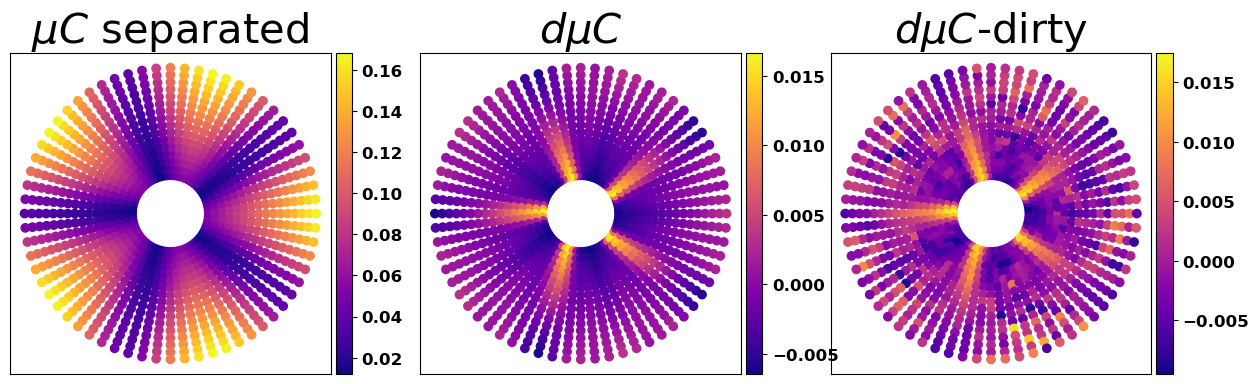

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(3*5, 5))

i = 0
clean_plot(fig, ax[i], X, Y, np.outer(μC_r_fun(r_grid), μC_θ_fun(θ_grid)))
ax[i].set_title(fr"$\mu C$ separated", fontsize=30)

i = 1
clean_plot(fig, ax[i], X, Y, dμC_fun(r_grid[:,None],θ_grid[None,:]) )
ax[i].set_title(fr"$d\mu C$", fontsize=30)

i = 2
clean_plot(fig, ax[i], X, Y, dμC )
ax[i].set_title(fr"$d\mu C$-dirty", fontsize=30)

plt.show()

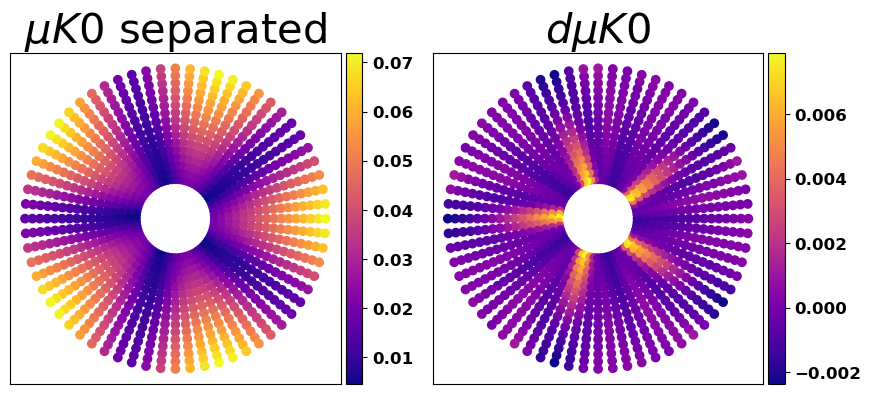

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(2*5, 5))

i = 0
clean_plot(fig, ax[i], X, Y, np.outer(μK0_r_fun(r_grid), μC_θ_fun(θ_grid)))
ax[i].set_title(fr"$\mu K0$ separated", fontsize=30)

i = 1
clean_plot(fig, ax[i], X, Y, dμK0_fun(r_grid[:,None],θ_grid[None,:]) )
ax[i].set_title(fr"$d\mu K0$", fontsize=30)

plt.show()

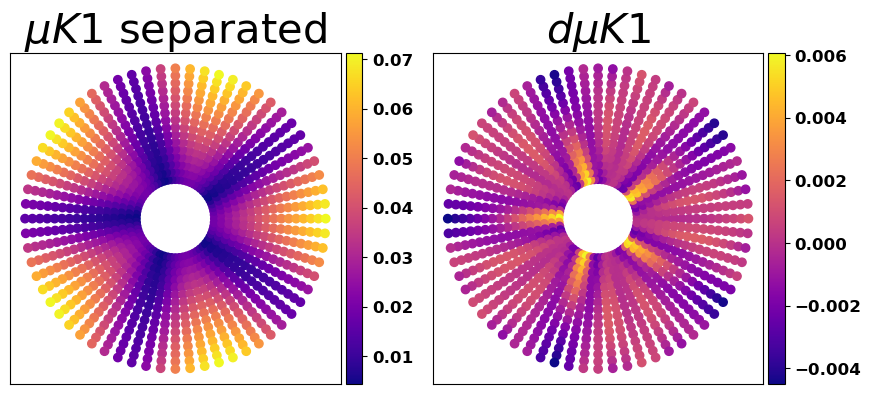

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(2*5, 5))

i = 0
clean_plot(fig, ax[i], X, Y, np.outer(μK1_r_fun(r_grid), μC_θ_fun(θ_grid)))
ax[i].set_title(fr"$\mu K1$ separated", fontsize=30)

i = 1
clean_plot(fig, ax[i], X, Y, dμK1_fun(r_grid[:,None],θ_grid[None,:]) )
ax[i].set_title(fr"$d\mu K1$", fontsize=30)

plt.show()

## Solve ODEs

In [20]:
import dedalus.public as d3

<frozen importlib._bootstrap>:488: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:488: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject


In [21]:
def seperated_problem(Nth,Nr,r0,r1,ith,ir,ith_type="real"):

    dtype = np.complex128
    
    def angular_problem(Nth,ith,ith_type):
    
        coord = d3.Coordinate('theta')
        dist  = d3.Distributor(coord, dtype=dtype)
        basis = d3.Fourier(coord, Nth, bounds=(0, 2*np.pi), dtype=dtype)
        
        T = dist.Field(bases=basis)
        q = dist.Field()
        
        θ  = dist.local_grid(basis)
        dθ = lambda A: d3.Differentiate(A, coord)
        
        u = dist.Field(bases=basis)
        u['g'] = μC_θ_fun(θ)
        
        problem = d3.EVP([T], eigenvalue = q, namespace=locals()) 
        problem.add_equation("dθ(u * dθ(T)) + q * u * T = 0")
        
        solver = problem.build_solver() 
        solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
        eigs = solver.eigenvalues.real
        ith = np.argsort(eigs)[ith]
        solver.set_state(ith, solver.subsystems[0])
        
        if ith_type == "real":
            T['g'] = (T['g']/T['g'][1]).real
        elif ith_type == "imag":
            T['g'] = (T['g']/T['g'][1]).imag

        T['g'] /= (d3.integ(T**2)['g']**0.5)
        
        return eigs[ith], θ, T['g'].real

    def radial_problem(Nr,r0, r1, q, ir):
        
        coord = d3.Coordinate('r')
        dist  = d3.Distributor(coord, dtype=dtype)
        basis = d3.Chebyshev(coord, Nr, bounds=(r0, r1))
        
        S    = dist.Field(bases=basis)
        kk   = dist.Field()
        tau0 = dist.Field()
        tau1 = dist.Field()
        
        # Substitutions
        lift_basis = basis.derivative_basis(2)
        lift = lambda A, n: d3.Lift(A, lift_basis, n)
        Res = lift(tau0, -1) + lift(tau1, -2)
        
        radius  = dist.local_grid(basis)
        dr = lambda A: d3.Differentiate(A, coord)
        
        r = dist.Field(bases=basis)
        r['g'] = radius
                
        muC  = dist.Field(bases=basis)
        muK0 = dist.Field(bases=basis)
        muK1 = dist.Field(bases=basis)
        
        muC['g']  =  μC_r_fun(radius)
        muK0['g'] = μK0_r_fun(radius)
        muK1['g'] = μK1_r_fun(radius)
        
        problem = d3.EVP([S, tau0, tau1], eigenvalue = kk, namespace=locals()) 
        problem.add_equation("r * dr(r * muK0 * dr(S)) + (r**2 * muC * kk - muK1 * q) * S + Res = 0")
        problem.add_equation("S(r=r0)=0")
        problem.add_equation("S(r=r1)=0")
        
        solver = problem.build_solver() 
        solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
        eigs  = solver.eigenvalues.real
        ir = np.argsort(eigs)[ir]
        solver.set_state(ir, solver.subsystems[0])
        
        S['g'] = S['g'].real
        
        S['g'] /= d3.integ(S**2)['g']**0.5
        
        return eigs[ir]**0.5, radius, S['g'].real
    
    q, theta, T = angular_problem(Nth,ith,ith_type)
    
    k, radius, S = radial_problem(Nr,r0, r1, q, ir)
    
    return k, radius, S.real, theta, T

In [22]:
def full_problem(Nr, Nth, inner_r, outer_r, ir, ith, ith_type="real"):
    
    k, radius, S, theta, T = seperated_problem(Nth, Nr, inner_r, outer_r, ith, ir, ith_type)
    
    dtype = np.float64
        
    # Bases
    coords = d3.PolarCoordinates('θ', 'r')
    dist = d3.Distributor(coords, dtype=dtype)
    ring = d3.AnnulusBasis(coords, shape=(Nth, Nr), radii=(inner_r, outer_r), dtype=dtype)
    theta, radius = dist.local_grids(ring)
    
    # Fields
    F  = dist.Field(bases=ring)
    G  = dist.VectorField(coords,bases=ring)
    C0 = dist.Field(bases=ring)
    C1 = dist.Field(bases=ring)
    K1 = dist.TensorField(coords,bases=ring)

    C0['g'] = μC_r_fun(radius) * μC_θ_fun(theta)
    C1['g'] = dμC_fun(radius,theta)
    K1['g'][0,0] = dμK0_fun(radius,theta)
    K1['g'][1,1] = dμK1_fun(radius,theta)
     
    F['g']  = T[:,None] * S[None,:]
    F['g'] /= d3.integ(F * C0 * F)['g']**0.5
    G = d3.grad(F)
    
    dk = d3.integ(G @ K1 @ G - (k**2) * F * C1 * F)['g'][0,0]/(2*k)
        
    return k+dk, dk, radius, theta, F['g'], T, S

In [23]:
graph_eigs = np.array([2.3346153 ,              # [0, 0]
                       2.61183765, 2.63565054,  # [0, 1]
                       3.07865221, 3.09446164,  # [0, 3]
                       4.75157494,              # [1, 0]
                       4.76290304, 4.65039931,  # [0, 5]
                       4.86941166, 4.92042802]) # [1, 1]

2025-06-26 00:00:11,209 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s
2025-06-26 00:00:12,482 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s
4.776311283516018

4.776311283516018 0.09258067748477504 -54.350314826200865 -51.35849627243218


/var/folders/8b/5pwswrrj2_1fnds4rv56brqw0000gp/T/ipykernel_76757/871121364.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, G, cmap='plasma')


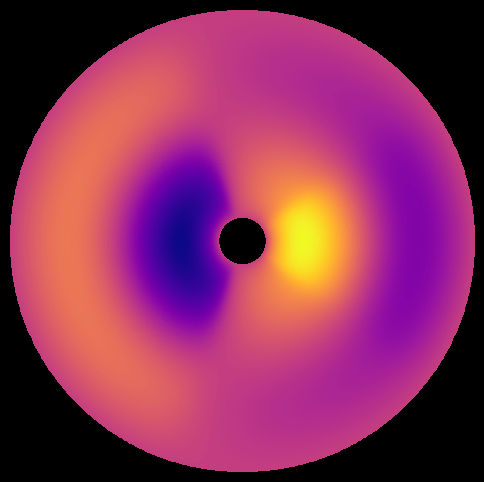

In [24]:
def percent_error(i,k):
    return 100*(graph_eigs[i]-k)/graph_eigs[i]

ir, ith = 1, 1

g = 4

k, dk, radius, theta, G, _, _ = full_problem(256, 512,0.1,1.0,ir,ith,ith_type="real")
print(k)

X, Y = radius * np.cos(theta), radius * np.sin(theta)

print()
print(k,dk,percent_error(g,k),percent_error(g,k-dk))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolormesh(X, Y, G, cmap='plasma')
ax.axis('off')

fig.set_facecolor('black')

plt.show()

In [ ]:
# Eigs from PDE solves^

# [ 2.2347823   4.45749233  6.67831389  8.899472   11.12105165 13.34294758]
# [ 2.58204808  4.77631128  6.95598322  9.14105084 11.3340731  13.53390956]
# [ 2.58204808  4.77631128  6.95598322  9.14105084 11.3340731  13.53390956]
# [ 3.1451695   5.42900463  7.6167505   9.76616941 11.91181587 14.06689123]
# [ 3.1451695   5.42900463  7.6167505   9.76616941 11.91181587 14.06689123]
# [ 4.48840691  6.56103279  8.52454054 10.46052782 12.40625937 14.38137351]
# [ 4.48840691  6.56103279  8.52454054 10.46052782 12.40625937 14.38137351]
# [ 5.03098646  7.25360766  9.35859184 11.41575441 13.44712208 15.46374677]
# [ 5.03098646  7.25360766  9.35859184 11.41575441 13.44712208 15.46374677]
# [ 5.45044216  7.80769627 10.04558377 12.23214089 14.38373545 16.50113516]

In [ ]:
# Ordered pde_eigs

pde_eigs = np.array([2.2347823 ,              # [0, 0]
                     2.58204808, 2.58204808,  # [0, 1]
                     3.1451695, 3.1451695,    # [0, 3]
                     4.45749233,              # [1, 0]
                     4.48840691, 4.48840691,  # [0, 5]
                     4.77631128, 4.77631128]) # [1, 1]

In [167]:
with open('/Users/sholden/repos/metric_graph/next_calculations/random_inhomogeneous/for_paper/pde_modes.pkl', "wb") as file:
    pickle.dump(eigendata, file)

coords = [radius.flatten(), theta.flatten()]

with open('/Users/sholden/repos/metric_graph/next_calculations/random_inhomogeneous/for_paper/pde_coords.pkl', "wb") as file:
    pickle.dump(coords, file)